In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [9]:
# Use Otsu's thresholding to determine blocksize and number of iterations
def otsuSize(imgName):
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold using value calculated by Otsu's Binarization
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Remove noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(blur,cv2.MORPH_OPEN,kernel, iterations=2)

    #plt.subplot(1, 2, 1), plt.imshow(gray, 'gray')
    #plt.title('Original')
    #plt.subplot(1, 2, 2), plt.imshow(thresh, 'gray')
    # Title shows threshold value calculated using Otsu's
    #plt.title('Threshold ' + str(ret))
    #plt.show()

    output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    stats = output[2]
    count = output[0] - 1 # background doesn't count as a scale
    
    # calculate average size of scales detected using Otsu's thresholding
    avgScaleSize = np.average(stats[1:,-1])
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    avgScaleSizeProportion = avgScaleSize / totalPixels
    # divide average scale size by total pixels because every image has different total number of pixels, and
    # we want to know the relative size of the scales in proportion to the size of the entire image
    
    # small scales
    if avgScaleSizeProportion < 0.01:
        blockSize = 15
        iterations = 1
    # medium sized scales, or extremely large scales (probably scales blended together)
    elif avgScaleSizeProportion < 0.035 or avgScaleSizeProportion > 0.2:
        blockSize = 35
        iterations = 2
    # large scales
    else:
        blockSize = 55
        iterations = 2
        
    countScales(imgName, blockSize, iterations)

In [10]:
def countScales(imgName, blockSize, openingIterations=2):   
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blur and adaptive thresholding
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, -2)

    # Remove noise by opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=openingIterations)
    
    # Check if opening was too much
    numWhitePixels = cv2.countNonZero(opening) # number of foreground pixels
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    if numWhitePixels / totalPixels < 0.3:
        # if opening resulted in less than 30% foreground, decrease number of opening iterations
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=1)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    output = cv2.connectedComponentsWithStats(sure_fg, 8, cv2.CV_32S)
    labels = output[1]
    count = output[0] - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    stats = output[2]
    roundnessList = []
    # calculate average roundness of detected scales
    for i in range(1, count + 1): # start at 1 instead of 0 because don't want to count background as a scale
        scaleArea = stats[i, cv2.CC_STAT_AREA]
        boxArea = stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]
        roundnessList.append(scaleArea / boxArea)
    avgRoundness = sum(roundnessList) / len(roundnessList)
    
    # if roundess is too low, do adaptive threshoding again using a smaller blocksize (unless blocksize is already really small)
    if avgRoundness < 0.7 and blockSize > 15:
        countScales(imgName, blockSize - 20, openingIterations)
    else:
        # display final results
        print('Blocksize: ' + str(blockSize))
        print('Number of iterations: ' + str(openingIterations))
        plt.subplot(1, 5, 1), plt.imshow(gray, 'gray')
        plt.title('Original')
        
        plt.subplot(1, 5, 2), plt.imshow(thresh, 'gray')
        plt.title('Threshold')
        
        plt.subplot(1, 5, 3), plt.imshow(opening, 'gray')
        plt.title('Opening')
        
        plt.subplot(1, 5, 4), plt.imshow(sure_fg, 'gray')
        plt.title('Sure fg')
        
        plt.subplot(1, 5, 5), plt.imshow(labeled_img, 'gray')
        plt.title('Count: ' + str(count))
        plt.show()

212019Ventral-NoFlash-3.png
Blocksize: 35
Number of iterations: 2


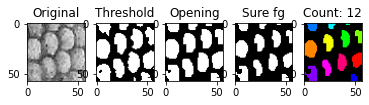

212019Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


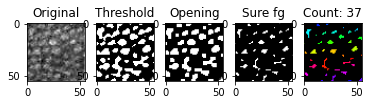

251165Ventral-NoFlash-2.png
Blocksize: 15
Number of iterations: 2


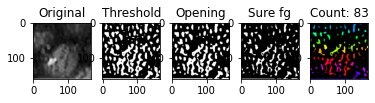

251165Ventral-Flash-3.png
Blocksize: 35
Number of iterations: 2


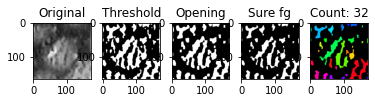

212018Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


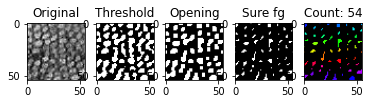

212018Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


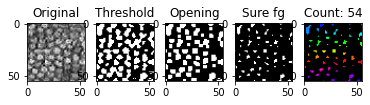

214993Dorsal-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


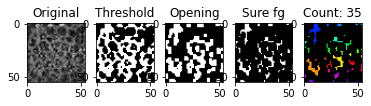

251165Ventral-Flash-2.png
Blocksize: 15
Number of iterations: 2


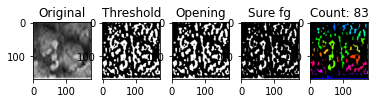

251165Ventral-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


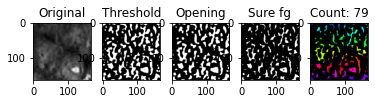

212019Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


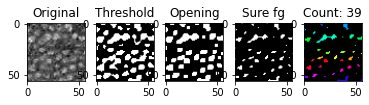

212019Ventral-NoFlash-2.png
Blocksize: 35
Number of iterations: 2


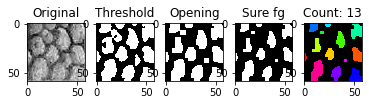

212019Dorsal-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


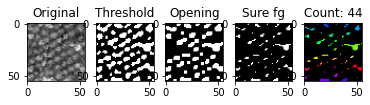

251165Ventral-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


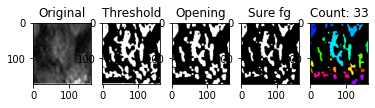

214993Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 2


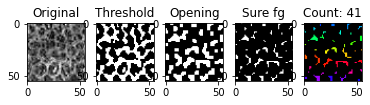

212018Dorsal-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


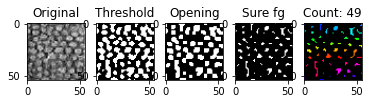

214993Dorsal-NoFlash-2.png
Blocksize: 35
Number of iterations: 2


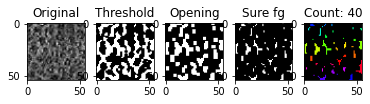

251165Ventral-Flash-1.png
Blocksize: 35
Number of iterations: 2


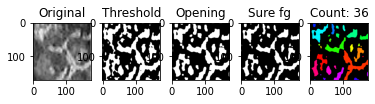

212019Ventral-NoFlash-1.png
Blocksize: 55
Number of iterations: 2


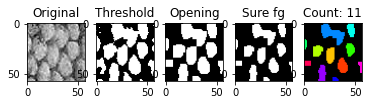

226121Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


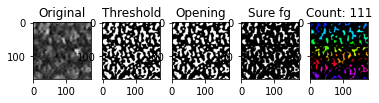

226123Dorsal-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


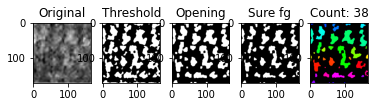

226121Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


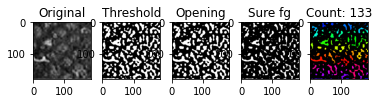

226121Dorsal-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


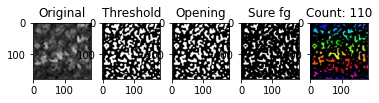

226123Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


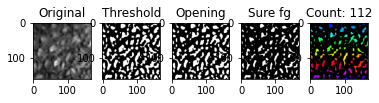

251165Dorsal-NoFlash-4.png
Blocksize: 15
Number of iterations: 1


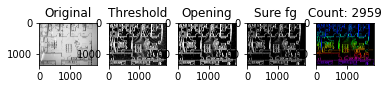

226123Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


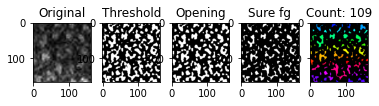

214993Ventral-Flash-3.png
Blocksize: 15
Number of iterations: 1


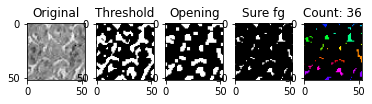

226123Dorsal-Flash-2.png
Blocksize: 15
Number of iterations: 1


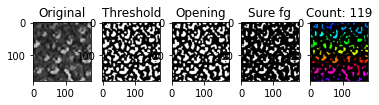

212018Ventral-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


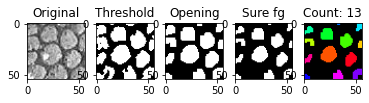

226123Dorsal-Flash-3.png
Blocksize: 15
Number of iterations: 1


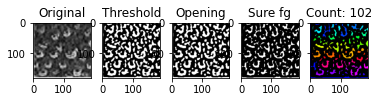

251165Dorsal-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


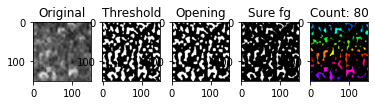

212020Ventral-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


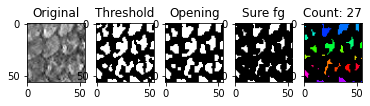

214993Ventral-Flash-2.png
Blocksize: 15
Number of iterations: 1


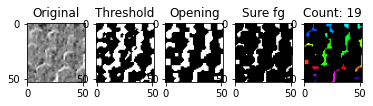

212020Ventral-NoFlash-3.png
Blocksize: 35
Number of iterations: 2


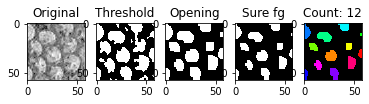

226123Dorsal-NoFlash-4.png
Blocksize: 15
Number of iterations: 1


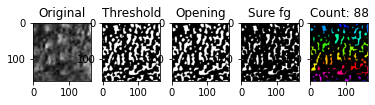

251165Dorsal-NoFlash-3.png
Blocksize: 35
Number of iterations: 2


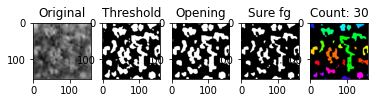

226123Dorsal-Flash-1.png
Blocksize: 15
Number of iterations: 1


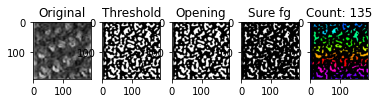

212018Ventral-NoFlash-3.png
Blocksize: 35
Number of iterations: 2


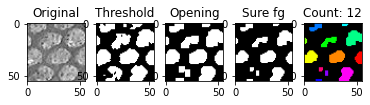

212018Ventral-NoFlash-2.png
Blocksize: 35
Number of iterations: 2


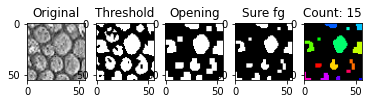

251165Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


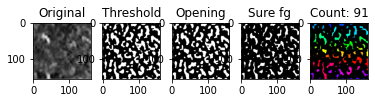

212020Ventral-NoFlash-2.png
Blocksize: 15
Number of iterations: 2


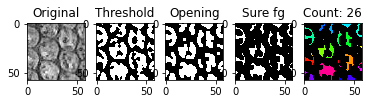

214993Ventral-Flash-1.png
Blocksize: 15
Number of iterations: 2


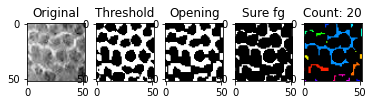

226123Ventral-Flash-3.png
Blocksize: 15
Number of iterations: 2


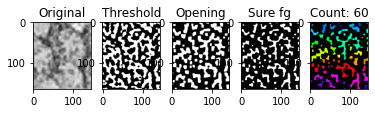

212020Dorsal-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


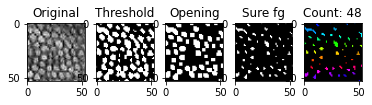

212020Dorsal-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


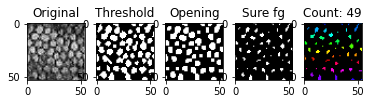

226123Ventral-Flash-2.png
Blocksize: 15
Number of iterations: 2


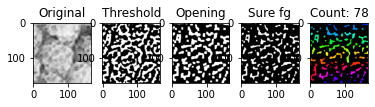

212020Dorsal-NoFlash-1.png
Blocksize: 15
Number of iterations: 1


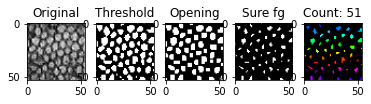

226123Ventral-Flash-1.png
Blocksize: 15
Number of iterations: 2


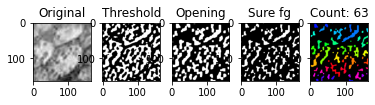

226121Ventral-NoFlash-3.png
Blocksize: 35
Number of iterations: 2


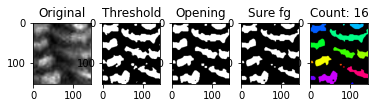

212010Ventral-NoFlash-2.png
Blocksize: 15
Number of iterations: 1


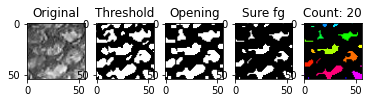

212010Ventral-NoFlash-3.png
Blocksize: 55
Number of iterations: 2


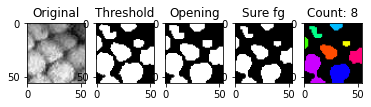

226121Ventral-NoFlash-2.png
Blocksize: 55
Number of iterations: 2


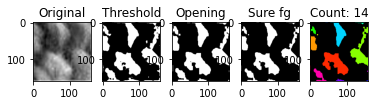

212010Ventral-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


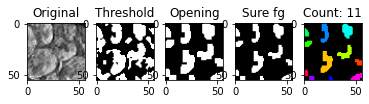

226121Ventral-NoFlash-1.png
Blocksize: 35
Number of iterations: 2


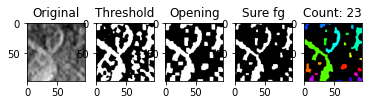

214993Ventral-NoFlash-1.png
Blocksize: 55
Number of iterations: 2


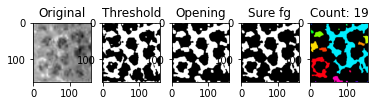

214993Ventral-NoFlash-3.png
Blocksize: 15
Number of iterations: 1


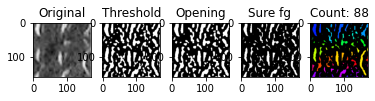

214993Ventral-NoFlash-2.png
Blocksize: 15
Number of iterations: 2


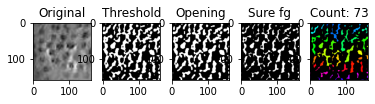

In [11]:
dirName = 'Anolis_cristatellus_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)

235227Ventral-Flash-1.png
Blocksize: 15
Number of iterations: 2


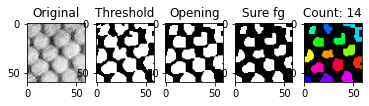

235227Ventral-NoFlash-1.png
Blocksize: 55
Number of iterations: 2


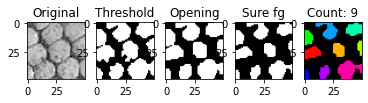

235227Ventral-Flash-2.png
Blocksize: 35
Number of iterations: 2


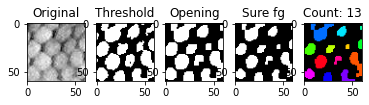

235227Ventral-NoFlash-2.png
Blocksize: 55
Number of iterations: 2


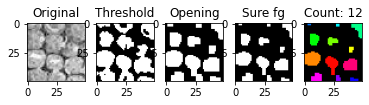

135164_V-3png.png
Blocksize: 55
Number of iterations: 2


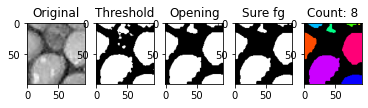

135164_V-1.png
Blocksize: 55
Number of iterations: 2


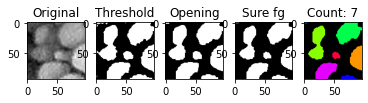

135164_V-2.png
Blocksize: 55
Number of iterations: 2


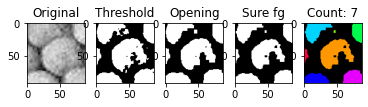

135164_D-3.png
Blocksize: 15
Number of iterations: 2


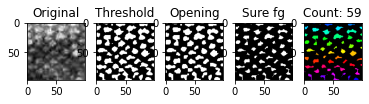

135164_D-2.png
Blocksize: 35
Number of iterations: 2


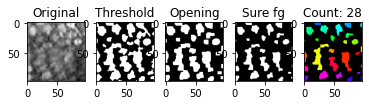

235237Dorsal-Flash-2.png
Blocksize: 35
Number of iterations: 2


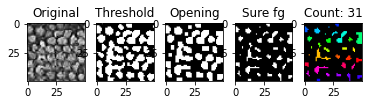

135164_D-1.png
Blocksize: 35
Number of iterations: 2


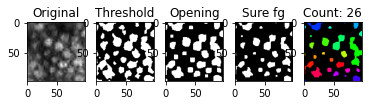

235237Dorsal-Flash-1.png
Blocksize: 15
Number of iterations: 1


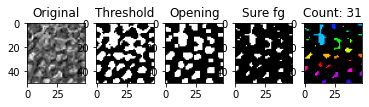

235233Dorsal-Flash-1.png
Blocksize: 15
Number of iterations: 1


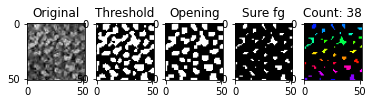

In [12]:
dirName = 'More_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)

S5.PNG
Blocksize: 15
Number of iterations: 2


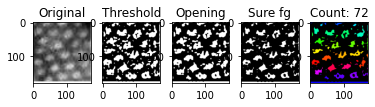

S4.png
Blocksize: 15
Number of iterations: 2


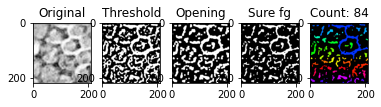

S1.png
Blocksize: 15
Number of iterations: 2


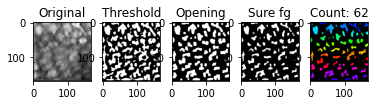

S3.png
Blocksize: 15
Number of iterations: 2


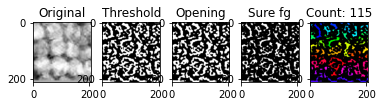

S2.png
Blocksize: 15
Number of iterations: 2


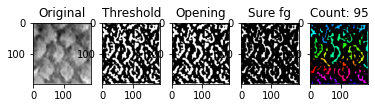

In [13]:
dirName = 'Scale_images'
for img in os.scandir(dirName):
    if img.name != '.DS_Store': #not sure why, but there's some invisible .DS_Store files in this folder
        print(img.name)
        otsuSize(dirName + "/" + img.name)

257349_ventral-5-.png
Blocksize: 55
Number of iterations: 2


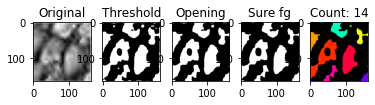

135164_D-3-.png.png
Blocksize: 15
Number of iterations: 1


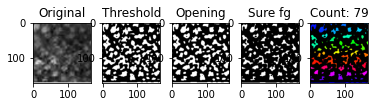

Screenshot 2020-11-16 at 4.15.13 PM.png
Blocksize: 35
Number of iterations: 2


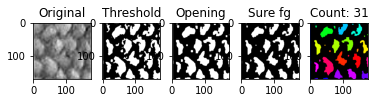

235180_ventral-4-.png
Blocksize: 15
Number of iterations: 1


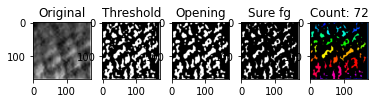

257349_ventral-4-.png
Blocksize: 35
Number of iterations: 2


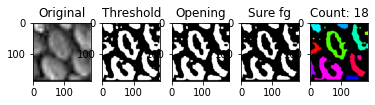

Screenshot 2020-11-16 at 4.15.23 PM.png
Blocksize: 15
Number of iterations: 2


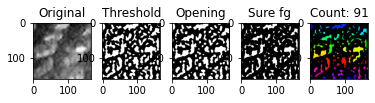

Screenshot 2020-11-16 at 5.00.35 PM.png
Blocksize: 15
Number of iterations: 2


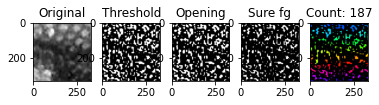

257349_ventral-3-.png
Blocksize: 15
Number of iterations: 2


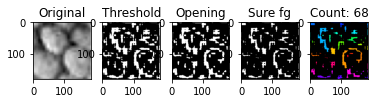

235180_ventral-3-.png
Blocksize: 15
Number of iterations: 2


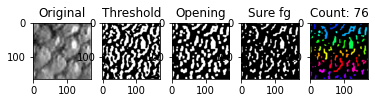

135164_D.png-5-.png
Blocksize: 15
Number of iterations: 1


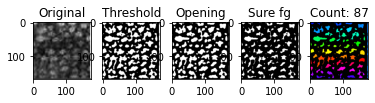

135164_D.png-4-.png
Blocksize: 35
Number of iterations: 2


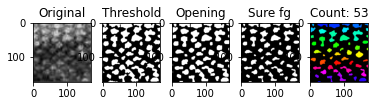

Screenshot 2020-11-16 at 4.15.34 PM.png
Blocksize: 35
Number of iterations: 2


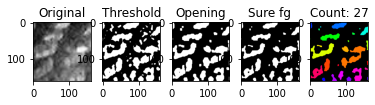

big_img.png
Blocksize: 15
Number of iterations: 1


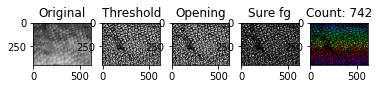

135164_D-7-.png
Blocksize: 15
Number of iterations: 2


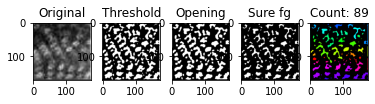

135164_D-6-.png
Blocksize: 15
Number of iterations: 1


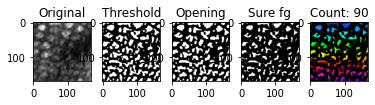

135164_D-2.png.png
Blocksize: 15
Number of iterations: 2


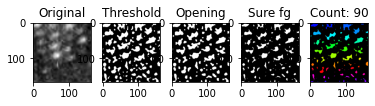

257349_ventral.png
Blocksize: 55
Number of iterations: 2


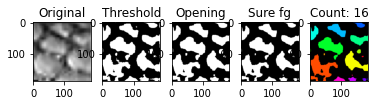

In [14]:
dirName = 'grouped_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)